In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import talib as ta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:

# 1. 读取数据
df = pd.read_csv('data/spot/binance/15m/BTC_USDT.csv')

# 选择时间范围
START_DATE = '2023-06-01'
END_DATE = '2025-06-30'
# 确保时间列为datetime类型
df['datetime'] = pd.to_datetime(df['datetime'])
data = df[(df['datetime'] >= START_DATE) & (df['datetime'] <= END_DATE)]

In [4]:
data

,datetime,open,high,low,close,volume
84538,2023-06-01 00:00:00,27210.36,27350.00,27198.00,27318.11,843.33387
84539,2023-06-01 00:15:00,27318.11,27338.80,27281.26,27281.27,447.97561
84540,2023-06-01 00:30:00,27281.26,27297.20,27065.84,27111.73,932.19792
84541,2023-06-01 00:45:00,27111.73,27111.73,27023.35,27065.77,549.31703
84542,2023-06-01 01:00:00,27065.76,27145.52,27059.74,27126.40,380.74336
...,...,...,...,...,...,...
157494,2025-06-29 23:00:00,108079.91,108261.66,108013.28,108054.26,102.69338
157495,2025-06-29 23:15:00,108054.25,108426.00,108024.12,108388.99,190.22441
157496,2025-06-29 23:30:00,108388.99,108436.47,108300.00,108300.01,133.57727
157497,2025-06-29 23:45:00,108300.00,108415.51,108300.00,108356.93,87.40906


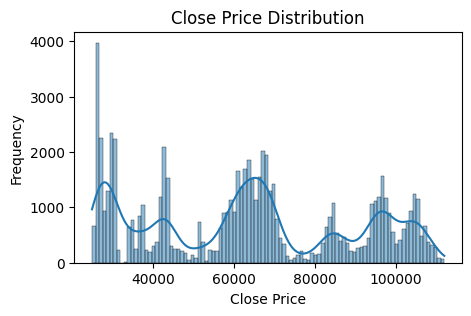

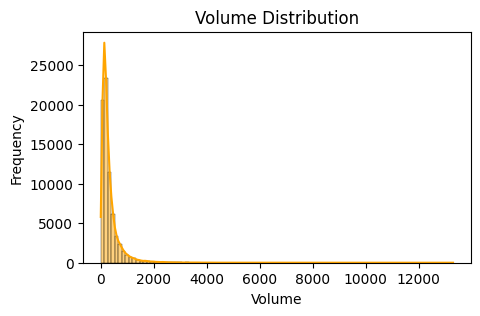

                open           high            low          close  \
count   72961.000000   72961.000000   72961.000000   72961.000000   
mean    63331.129743   63435.674913   63223.563573   63332.241442   
std     25915.526686   25961.765073   25868.985485   25915.720301   
min     24893.100000   24926.790000   24800.000000   24893.090000   
25%     40661.810000   40779.660000   40532.170000   40679.970000   
50%     63464.770000   63582.000000   63343.470000   63465.410000   
75%     85502.030000   85690.020000   85329.270000   85502.170000   
max    111898.740000  111980.000000  111681.810000  111898.740000   

             volume  
count  72961.000000  
mean     340.541351  
std      427.859641  
min        3.985380  
25%      126.941280  
50%      216.317980  
75%      391.761020  
max    13289.889260  


,datetime,open,high,low,close,volume
count,72961,72961.000000,72961.000000,72961.000000,72961.000000,72961.000000
mean,2024-06-15 00:00:00,63331.129743,63435.674913,63223.563573,63332.241442,340.541351
min,2023-06-01 00:00:00,24893.100000,24926.790000,24800.000000,24893.090000,3.985380
25%,2023-12-08 00:00:00,40661.810000,40779.660000,40532.170000,40679.970000,126.941280
50%,2024-06-15 00:00:00,63464.770000,63582.000000,63343.470000,63465.410000,216.317980
75%,2024-12-22 00:00:00,85502.030000,85690.020000,85329.270000,85502.170000,391.761020
max,2025-06-30 00:00:00,111898.740000,111980.000000,111681.810000,111898.740000,13289.889260
std,NaN,25915.526686,25961.765073,25868.985485,25915.720301,427.859641


In [5]:

# 2. 数据预处理，做一些初步的数据统计分布描述

# 绘制价格分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['close'], bins=100, kde=True)
plt.title('Close Price Distribution')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# 绘制成交量分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['volume'], bins=100, kde=True, color='orange')
plt.title('Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

# 计算并显示主要数值特征的描述性统计
print(data[['open', 'high', 'low', 'close', 'volume']].describe())
data.describe()


In [6]:

# 2. 特征工程（示例：用常见技术指标）
"""
技术指标列表
趋势: EMA (20, 60, 100, 200), MACD (12,26,9; 5,35,5), ADX (14)
动量: RSI (10, 20, 60), %K Stochastic (10, 30, 200)
反转: ROC(RSI) (10, 20, 50)
振幅: ATR (20, 60, 100), Bollinger Bands (20, 2)
成交量: OBV, VWAP
短期动态: MOM (10, 30, 50), PROC (10, 50)
"""

# 用talib计算特征，全部用talib函数

# 用talib计算特征，全部用talib函数
data['ema_20'] = ta.EMA(data['close'], timeperiod=20)
data['ema_60'] = ta.EMA(data['close'], timeperiod=60)
data['ema_100'] = ta.EMA(data['close'], timeperiod=100)
data['ema_200'] = ta.EMA(data['close'], timeperiod=200)

macd_20_60, macdsignal_20_60, macdhist_20_60 = ta.MACD(data['close'], fastperiod=20, slowperiod=60, signalperiod=9)
macd_10_20, macdsignal_10_20, macdhist_10_20 = ta.MACD(data['close'], fastperiod=10, slowperiod=20, signalperiod=5)
data['macd_20_60'] = macd_20_60
data['macd_10_20'] = macd_10_20

data['adx_10'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=10)
data['adx_20'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=20)
data['adx_60'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=60)

data['rsi_7'] = ta.RSI(data['close'], timeperiod=7)
data['rsi_20'] = ta.RSI(data['close'], timeperiod=20)
data['rsi_60'] = ta.RSI(data['close'], timeperiod=60)

slowk_10, slowd_10 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=10, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
slowk_30, slowd_30 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=30, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
slowk_100, slowd_100 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=100, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
data['stoch_k_10'] = slowk_10
data['stoch_k_30'] = slowk_30
data['stoch_k_100'] = slowk_100

data['roc_rsi_10'] = ta.ROC(data['rsi_7'], timeperiod=10)
data['roc_rsi_20'] = ta.ROC(data['rsi_7'], timeperiod=20)
data['roc_rsi_50'] = ta.ROC(data['rsi_7'], timeperiod=50)

data['atr_20'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=20)
data['atr_60'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=60)
data['atr_100'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=100)

# talib没有直接的Bollinger带宽和百分比，需手动计算
upper, middle, lower = ta.BBANDS(data['close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
data['bb_width'] = upper - lower
data['bb_percent'] = (data['close'] - lower) / (upper - lower)

data['obv'] = ta.OBV(data['close'], data['volume'])

# VWAP简单实现
data['vwap'] = (data['volume'] * (data['high'] + data['low'] + data['close']) / 3).cumsum() / data['volume'].cumsum()

data['mom_5'] = ta.MOM(data['close'], timeperiod=5)
data['mom_20'] = ta.MOM(data['close'], timeperiod=20)
data['mom_50'] = ta.MOM(data['close'], timeperiod=50)

data['proc_5'] = ta.ROC(data['close'], timeperiod=5)
data['proc_20'] = ta.ROC(data['close'], timeperiod=20)

data['vol_ma_20'] = data['volume'].rolling(window=20).mean()
data['vol_ma_60'] = data['volume'].rolling(window=60).mean()

C:\Users\hp\AppData\Local\Temp\ipykernel_27908\1518125282.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ema_20'] = ta.EMA(data['close'], timeperiod=20)
C:\Users\hp\AppData\Local\Temp\ipykernel_27908\1518125282.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ema_60'] = ta.EMA(data['close'], timeperiod=60)
C:\Users\hp\AppData\Local\Temp\ipykernel_27908\1518125282.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [11]:
TARGET_PERIOD = 1
# T-1 到 T+4 的涨跌为目标
# >0 为正样本，<=0为负样本，符合lightgbm的二分类标记
data['target'] = (data['close'].shift(-TARGET_PERIOD) - data['close'] > 0).astype(int)

# 删除含有NaN值的行
data.dropna(inplace=True)  

C:\Users\hp\AppData\Local\Temp\ipykernel_27908\1763831794.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = (data['close'].shift(-TARGET_PERIOD) - data['close'] > 0).astype(int)
C:\Users\hp\AppData\Local\Temp\ipykernel_27908\1763831794.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [12]:


# 划分特征和目标
feature_cols = [col for col in data.columns if col not in ['datetime', 'target']]
X = data[feature_cols]
y = data['target']

    # 划分训练集和验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, shuffle=False)

# 正则归一化（标准化）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [13]:
X_train.shape

(58208, 37)

In [14]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([28928, 29280], dtype=int64))

In [18]:
# 训练 LightGBM 回归模型
lgb_train = lgb.Dataset(X_train_scaled, y_train)
lgb_val = lgb.Dataset(X_val_scaled, y_val)
lgb_test = lgb.Dataset(X_test_scaled, y_test)

params = {
    'num_leaves': 33,
    'min_data_in_leaf': 50,
    'objective': 'binary',
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_sum_hessian_in_leaf": 6,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.7,
    "bagging_seed": 11,
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    'metric': 'mse',
    "random_state": 2019,
    # 'device': 'gpu'
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
)

# 预测
y_pred_test = gbm.predict(X_test_scaled)

In [19]:
y_pred_test

array([0.52260838, 0.53908665, 0.54723924, ..., 0.36777107, 0.40424603,
       0.37587675])

Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.75      0.62      1480
           1       0.53      0.30      0.38      1431

    accuracy                           0.53      2911
   macro avg       0.53      0.52      0.50      2911
weighted avg       0.53      0.53      0.50      2911



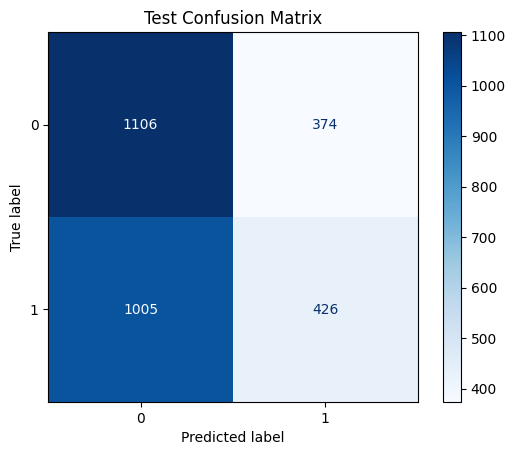

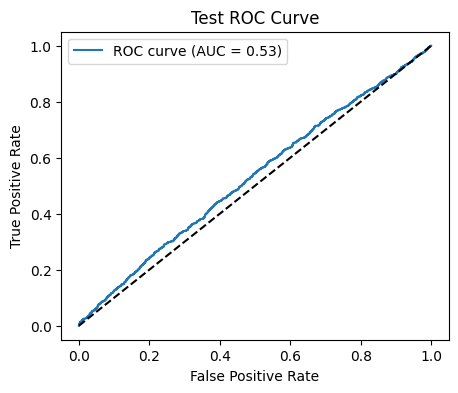

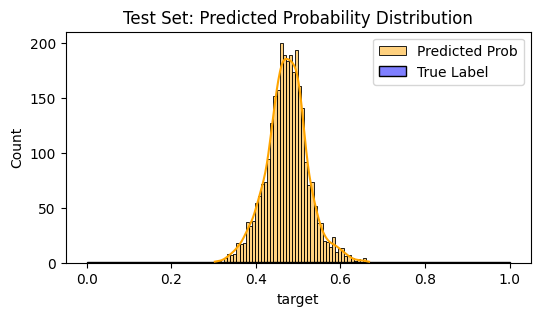

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# 阈值设为0.5，转为二分类标签
y_pred_test_cls = (y_pred_test > 0.5).astype(int)
y_train_pred = gbm.predict(X_train_scaled)
y_train_pred_cls = (y_train_pred > 0.5).astype(int)
y_val_pred = gbm.predict(X_val_scaled)
y_val_pred_cls = (y_val_pred > 0.5).astype(int)

# 1. 分类报告
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test_cls))

# 2. 混淆矩阵
cm = confusion_matrix(y_test, y_pred_test_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Test Confusion Matrix")
plt.show()

# 3. ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend()
plt.show()

# 4. 预测概率分布
plt.figure(figsize=(6,3))
sns.histplot(y_pred_test, bins=50, kde=True, color='orange', label='Predicted Prob')
sns.histplot(y_test, bins=2, color='blue', label='True Label', alpha=0.5, stat='density')
plt.legend()
plt.title('Test Set: Predicted Probability Distribution')
plt.show()
